### HeadStorm Data Science Challege : 

#### Description:
Can we use geographical coordinates paired with a timestamp representing someone's birth date to determine the meteorological season in which they were born? The challenge is to develop an algorithm accurately identifying a meteorological season based on the inputs of coordinates and birth date.

#### DataSet
For this challenge the data provided has 3 data points, Location (in terms of Latitute & Longitude) and Time of birth(in UTC format)

#### Approach:
1. Based on the time, fetch weather parameters like temperature, pressure, humidity etc from OpenWeatherAPI.com
2. Classify the data into 4 clusters based on location co-ordinates, birthdate and the added weather conditions 
3. After classification, identify and analyse properties of each cluster
4. Based on properties, identify which cluster represents closest season out of the 4 seasons : Winter/Spring/Summer/Fall
5. Once labels are identified, tag each tuple of (lat, long , birthdate) to the label of it's season
6. Since we now have data with ground truth of season, apply predictive ML algorithm to predict season for any new data point

#### Assumptions:
1. Season can be identified based on weather conditions and location
2. Season follow general characteristics  like: Winter will have maximum snowfall followed by Fall , Spring and Summer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
from sklearn.preprocessing import scale
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix ,recall_score, accuracy_score , f1_score , precision_score , roc_curve, auc
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_input = pd.read_csv("https://raw.githubusercontent.com/Headstorm/Interview/master/challenges/data/birthdays.csv")
df_input.head()

,Latitude,Longitude,Birth Date
0,41.197746,-88.15758,1524447636
1,41.488365,-87.75167,1528162636
2,40.973595,-87.57315,1517638013
3,35.314070,-116.94493,1545264278
4,50.545383,-111.17417,1545864456


In [3]:
df_input.shape

(500, 3)

In [4]:
def get_api_data(row):
    try:
        url = "http://api.openweathermap.org/data/2.5/weather?APPID=83fc79b1bf8672266036d3390337ba96&lat="+ str(row["Latitude"])+ "&lon=" + str(row["Longitude"])+"&start="+ str(row["Birth Date"])+"&end="+ str(row["Birth Date"])
        response = requests.get(url).text
        response_json = json.loads(response)
        return response_json
    except Exception as e:
        raise e

In [5]:
df_input["api_response"] = df_input.apply(get_api_data , axis=1)

In [6]:
df = df_input[:]
df.shape

(500, 4)

In [7]:
new_df = json_normalize(df["api_response"])
new_df.columns

Index(['weather', 'base', 'visibility', 'dt', 'timezone', 'id', 'name', 'cod',
       'coord.lon', 'coord.lat', 'main.temp', 'main.feels_like',
       'main.temp_min', 'main.temp_max', 'main.pressure', 'main.humidity',
       'wind.speed', 'wind.deg', 'clouds.all', 'sys.type', 'sys.id',
       'sys.country', 'sys.sunrise', 'sys.sunset', 'main.sea_level',
       'main.grnd_level', 'snow.3h', 'rain.3h', 'wind.gust', 'snow.1h',
       'rain.1h'],
      dtype='object')

In [8]:
def weather_length(weather):
    return len(weather)

In [9]:
df["weather_len"] = new_df["weather"].apply(weather_length)
list_index = df[df["weather_len"]>1].index
for i in list_index:
    temp = df.iloc[i,3]
    print(temp["weather"])

[{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}, {'id': 600, 'main': 'Snow', 'description': 'light snow', 'icon': '13n'}]
[{'id': 600, 'main': 'Snow', 'description': 'light snow', 'icon': '13n'}, {'id': 701, 'main': 'Mist', 'description': 'mist', 'icon': '50n'}]
[{'id': 600, 'main': 'Snow', 'description': 'light snow', 'icon': '13n'}, {'id': 701, 'main': 'Mist', 'description': 'mist', 'icon': '50n'}]
[{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}, {'id': 602, 'main': 'Snow', 'description': 'heavy snow', 'icon': '13n'}]
[{'id': 600, 'main': 'Snow', 'description': 'light snow', 'icon': '13n'}, {'id': 701, 'main': 'Mist', 'description': 'mist', 'icon': '50n'}]
[{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}, {'id': 701, 'main': 'Mist', 'description': 'mist', 'icon': '50n'}]
[{'id': 600, 'main': 'Snow', 'description': 'light snow', 'icon': '13n'}, {'id': 701, 'main': 'Mist', 'description': 'mist', 'icon': '50n'}]
[

As seen from above,there are a few conditions when weather column lists two different weather conditions, Rain&Snow , Snow&Mist etc. Assuming that the primary condition will be the first attribute in the list

In [10]:
new_df

,weather,base,visibility,dt,timezone,id,name,cod,coord.lon,coord.lat,...,sys.country,sys.sunrise,sys.sunset,main.sea_level,main.grnd_level,snow.3h,rain.3h,wind.gust,snow.1h,rain.1h
0,"[{'id': 804, 'main': 'Clouds', 'description': ...",stations,16093.0,1578831348,-21600,4885444,Braidwood,200,-88.16,41.20,...,US,1578835023,1578869047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'id': 804, 'main': 'Clouds', 'description': ...",stations,16093.0,1578831349,-21600,4901445,Matteson,200,-87.75,41.49,...,US,1578834975,1578868898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'id': 804, 'main': 'Clouds', 'description': ...",stations,16093.0,1578831349,-21600,4923796,Morocco,200,-87.57,40.97,...,US,1578834841,1578868945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'id': 800, 'main': 'Clear', 'description': '...",stations,16093.0,1578831349,-28800,5352950,Goldstone,200,-116.94,35.31,...,US,1578840995,1578876892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'id': 600, 'main': 'Snow', 'description': 'l...",stations,6437.0,1578831350,-25200,5986225,Jenner,200,-111.17,50.55,...,CA,1578842509,1578872608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,"[{'id': 804, 'main': 'Clouds', 'description': ...",stations,16093.0,1578831516,-21600,5080066,Taylor,200,-99.43,41.91,...,US,1578837852,1578871629,NaN,NaN,NaN,NaN,NaN,NaN,NaN
496,"[{'id': 600, 'main': 'Snow', 'description': 'l...",stations,4828.0,1578831516,-18000,4995201,Hancock,200,-89.23,47.44,...,US,1578836502,1578868081,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,"[{'id': 600, 'main': 'Snow', 'description': 'l...",stations,NaN,1578831516,-21600,5689239,Garrison,200,-101.41,47.81,...,US,1578839507,1578870924,NaN,NaN,0.19,NaN,NaN,NaN,NaN
498,"[{'id': 800, 'main': 'Clear', 'description': '...",stations,16093.0,1578831517,-25200,5840846,Thermopolis,200,-108.62,43.83,...,US,1578840411,1578873482,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def get_weather(weather):
    return weather[0]["main"] 

df['weather'] = new_df["weather"].apply(get_weather)
df.head()

,Latitude,Longitude,Birth Date,api_response,weather_len,weather
0,41.197746,-88.15758,1524447636,"{'coord': {'lon': -88.16, 'lat': 41.2}, 'weath...",1,Clouds
1,41.488365,-87.75167,1528162636,"{'coord': {'lon': -87.75, 'lat': 41.49}, 'weat...",1,Clouds
2,40.973595,-87.57315,1517638013,"{'coord': {'lon': -87.57, 'lat': 40.97}, 'weat...",1,Clouds
3,35.314070,-116.94493,1545264278,"{'coord': {'lon': -116.94, 'lat': 35.31}, 'wea...",1,Clear
4,50.545383,-111.17417,1545864456,"{'coord': {'lon': -111.17, 'lat': 50.55}, 'wea...",1,Snow


In [12]:
df[['weather2', 'base', 'visibility', 'dt', 'timezone', 'id', 'name', 'cod',
       'coord.lon', 'coord.lat', 'main.temp', 'main.feels_like',
       'main.temp_min', 'main.temp_max', 'main.pressure', 'main.humidity',
       'wind.speed', 'wind.deg', 'wind.gust', 'rain.1h', 'clouds.all',
       'sys.type', 'sys.id', 'sys.country', 'sys.sunrise', 'sys.sunset',
       'snow.1h', 'main.sea_level', 'main.grnd_level', 'snow.3h', 'rain.3h']] = new_df.loc[:,['weather', 'base', 'visibility', 'dt', 'timezone', 'id', 'name', 'cod',
                                                           'coord.lon', 'coord.lat', 'main.temp', 'main.feels_like',
                                                           'main.temp_min', 'main.temp_max', 'main.pressure', 'main.humidity',
                                                           'wind.speed', 'wind.deg', 'wind.gust', 'rain.1h', 'clouds.all',
                                                           'sys.type', 'sys.id', 'sys.country', 'sys.sunrise', 'sys.sunset',
                                                           'snow.1h', 'main.sea_level', 'main.grnd_level', 'snow.3h', 'rain.3h']]

In [13]:
# Removing irrelevant, internal columns
df = df.drop(columns = ['api_response','weather_len','weather2','base','dt','id','name','cod','coord.lon','coord.lat', 'sys.type' ,'sys.id'] )
df.head()

,Latitude,Longitude,Birth Date,weather,visibility,timezone,main.temp,main.feels_like,main.temp_min,main.temp_max,...,rain.1h,clouds.all,sys.country,sys.sunrise,sys.sunset,snow.1h,main.sea_level,main.grnd_level,snow.3h,rain.3h
0,41.197746,-88.15758,1524447636,Clouds,16093.0,-21600,268.93,264.73,268.15,270.15,...,NaN,90,US,1578835023,1578869047,NaN,NaN,NaN,NaN,NaN
1,41.488365,-87.75167,1528162636,Clouds,16093.0,-21600,268.99,265.11,267.59,270.93,...,NaN,90,US,1578834975,1578868898,NaN,NaN,NaN,NaN,NaN
2,40.973595,-87.57315,1517638013,Clouds,16093.0,-21600,269.78,265.66,268.71,271.15,...,NaN,90,US,1578834841,1578868945,NaN,NaN,NaN,NaN,NaN
3,35.314070,-116.94493,1545264278,Clear,16093.0,-28800,275.55,271.26,274.15,276.15,...,NaN,1,US,1578840995,1578876892,NaN,NaN,NaN,NaN,NaN
4,50.545383,-111.17417,1545864456,Snow,6437.0,-25200,254.63,246.27,254.26,255.15,...,NaN,90,CA,1578842509,1578872608,NaN,NaN,NaN,NaN,NaN


In [14]:
df.isna().sum()*100/len(df)

Latitude            0.0
Longitude           0.0
Birth Date          0.0
weather             0.0
visibility         25.4
timezone            0.0
main.temp           0.0
main.feels_like     0.0
main.temp_min       0.0
main.temp_max       0.0
main.pressure       0.0
main.humidity       0.0
wind.speed          0.0
wind.deg            2.0
wind.gust          89.0
rain.1h            96.6
clouds.all          0.0
sys.country         5.0
sys.sunrise         0.0
sys.sunset          0.0
snow.1h            98.2
main.sea_level     80.2
main.grnd_level    80.2
snow.3h            94.8
rain.3h            98.4
dtype: float64

As we can see clearly from above table, there are few columns which has more than 50 % of missing values. Imputing such columns with features won't give desirable results as it would lead to bias dataset. Therefore dropping such columns and not considering them for further analysis

In [15]:
df = df.drop(['wind.gust','rain.1h','snow.1h','main.sea_level','main.grnd_level','snow.3h','rain.3h'],axis=1)
df.head()

,Latitude,Longitude,Birth Date,weather,visibility,timezone,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.humidity,wind.speed,wind.deg,clouds.all,sys.country,sys.sunrise,sys.sunset
0,41.197746,-88.15758,1524447636,Clouds,16093.0,-21600,268.93,264.73,268.15,270.15,1025,86,2.10,280.0,90,US,1578835023,1578869047
1,41.488365,-87.75167,1528162636,Clouds,16093.0,-21600,268.99,265.11,267.59,270.93,1025,92,1.77,315.0,90,US,1578834975,1578868898
2,40.973595,-87.57315,1517638013,Clouds,16093.0,-21600,269.78,265.66,268.71,271.15,1025,86,2.10,280.0,90,US,1578834841,1578868945
3,35.314070,-116.94493,1545264278,Clear,16093.0,-28800,275.55,271.26,274.15,276.15,1018,64,2.60,40.0,1,US,1578840995,1578876892
4,50.545383,-111.17417,1545864456,Snow,6437.0,-25200,254.63,246.27,254.26,255.15,1012,70,6.70,320.0,90,CA,1578842509,1578872608


In [16]:
df.describe()

,Latitude,Longitude,Birth Date,visibility,timezone,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,main.humidity,wind.speed,wind.deg,clouds.all,sys.sunrise,sys.sunset
count,500.000000,500.000000,5.000000e+02,373.000000,500.00000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,490.000000,500.000000,5.000000e+02,5.000000e+02
mean,40.445500,-99.503836,1.535855e+09,14602.369973,-22809.60000,269.617440,264.641480,268.247600,270.85644,1018.486000,80.648000,3.89292,182.289796,62.320000,1.578838e+09,1.578872e+09
std,7.134425,13.228035,1.197194e+07,4644.612020,3573.03246,11.939075,13.103128,11.921207,12.12467,7.282573,13.622159,2.76448,101.904391,40.126473,3.416091e+03,3.424502e+03
min,28.133734,-122.882515,1.514999e+09,201.000000,-28800.00000,243.600000,238.600000,243.600000,243.60000,999.000000,32.000000,0.21000,1.000000,0.000000,1.578831e+09,1.578864e+09
25%,34.449331,-110.576325,1.525546e+09,16093.000000,-25200.00000,260.750000,254.555000,258.710000,262.15000,1014.000000,76.000000,2.04750,95.000000,1.000000,1.578835e+09,1.578869e+09
50%,40.149765,-99.873160,1.536211e+09,16093.000000,-21600.00000,269.640000,264.235000,267.945000,271.15000,1019.000000,83.000000,3.10000,179.500000,90.000000,1.578838e+09,1.578872e+09
75%,46.790332,-88.458377,1.546387e+09,16093.000000,-21600.00000,277.157500,272.782500,275.370000,278.82000,1024.000000,92.000000,5.10000,260.750000,90.000000,1.578840e+09,1.578874e+09
max,52.968180,-76.167390,1.556799e+09,40233.000000,-18000.00000,298.080000,296.280000,298.080000,298.08000,1038.000000,100.000000,17.50000,360.000000,100.000000,1.578846e+09,1.578879e+09


In [17]:
df.isna().sum()

Latitude             0
Longitude            0
Birth Date           0
weather              0
visibility         127
timezone             0
main.temp            0
main.feels_like      0
main.temp_min        0
main.temp_max        0
main.pressure        0
main.humidity        0
wind.speed           0
wind.deg            10
clouds.all           0
sys.country         25
sys.sunrise          0
sys.sunset           0
dtype: int64

In [18]:
# Filling the missing values for this columns with  the mean of remaining values
df['visibility'] = df['visibility'].fillna(df['visibility'].mean())
df['wind.deg'] = df['wind.deg'].fillna(df['wind.deg'].mean())

In [19]:
df["weather"].unique()

array(['Clouds', 'Clear', 'Snow', 'Fog', 'Rain', 'Mist', 'Drizzle'],
      dtype=object)

#### Encoding categorical variables

Creating custom encoders instead of standard OneHotEncoder / LabelEndoders. 
LabelEncoder would have encoded Rain, Clear , Clouds as 1 , 2 ,3 and so on. This would have made incorrect assumption of Rain -Clouds being further apart than Rain-Clear. To resolve this issue, using custom encoder. 

**1. Denormalizing weather column:**<br>
Each weather condition will be a seperate column denoting 0/1 depending upon what the climate was.
This helps maintaining uniform distance amongst all the seasons.For eg: Rain will be [1,0,0,0,0] and Clear will be [0,1,0,0,0] Hence the distance between any two seasons will be maintained to be root 2.  

In [20]:
def get_new_feature(df):
    for col in df['weather'].unique():
        df.loc[df['weather']==col,col] = 1
    df = df.fillna(0)
    return df

In [21]:
df2 = get_new_feature(df)
df2.head(15) 

,Latitude,Longitude,Birth Date,weather,visibility,timezone,main.temp,main.feels_like,main.temp_min,main.temp_max,...,sys.country,sys.sunrise,sys.sunset,Clouds,Clear,Snow,Fog,Rain,Mist,Drizzle
0,41.197746,-88.157580,1524447636,Clouds,16093.000000,-21600,268.93,264.73,268.15,270.15,...,US,1578835023,1578869047,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.488365,-87.751670,1528162636,Clouds,16093.000000,-21600,268.99,265.11,267.59,270.93,...,US,1578834975,1578868898,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.973595,-87.573150,1517638013,Clouds,16093.000000,-21600,269.78,265.66,268.71,271.15,...,US,1578834841,1578868945,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.314070,-116.944930,1545264278,Clear,16093.000000,-28800,275.55,271.26,274.15,276.15,...,US,1578840995,1578876892,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,50.545383,-111.174170,1545864456,Snow,6437.000000,-25200,254.63,246.27,254.26,255.15,...,CA,1578842509,1578872608,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,29.373638,-97.944320,1548972565,Clear,16093.000000,-21600,275.05,271.22,273.15,277.04,...,US,1578835634,1578873131,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,35.124146,-96.523360,1555512493,Clouds,16093.000000,-21600,271.96,266.44,271.15,272.59,...,US,1578836067,1578872016,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,28.417503,-101.606804,1555891024,Clouds,14602.369973,-21600,277.99,274.40,277.99,277.99,...,MX,1578836397,1578874130,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,41.934376,-94.590360,1543961664,Clear,16093.000000,-21600,263.23,258.57,260.93,264.82,...,US,1578836694,1578870463,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,28.954363,-87.621890,1520765198,Clouds,16093.000000,-21600,293.15,290.74,293.15,293.15,...,US,1578833105,1578870705,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**2. Encoding country column**

In [22]:
df2["sys.country"].value_counts()

US    359
CA     96
0      25
MX     20
Name: sys.country, dtype: int64

There are only 3 countries with values:  USA , Canada and Mexico available. Since all the three countries will follow same calendar, this attribute is no longer useful for determining useful cluster of data. Plus, location co-ordinates will take care of the country parameter.

In [23]:
#Dropping categorical weather column as well, since we have encoded column added
df2 = df2.drop(columns = ["sys.country" , "weather"]) 
df2.head()

,Latitude,Longitude,Birth Date,visibility,timezone,main.temp,main.feels_like,main.temp_min,main.temp_max,main.pressure,...,clouds.all,sys.sunrise,sys.sunset,Clouds,Clear,Snow,Fog,Rain,Mist,Drizzle
0,41.197746,-88.15758,1524447636,16093.0,-21600,268.93,264.73,268.15,270.15,1025,...,90,1578835023,1578869047,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.488365,-87.75167,1528162636,16093.0,-21600,268.99,265.11,267.59,270.93,1025,...,90,1578834975,1578868898,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.973595,-87.57315,1517638013,16093.0,-21600,269.78,265.66,268.71,271.15,1025,...,90,1578834841,1578868945,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.314070,-116.94493,1545264278,16093.0,-28800,275.55,271.26,274.15,276.15,1018,...,1,1578840995,1578876892,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,50.545383,-111.17417,1545864456,6437.0,-25200,254.63,246.27,254.26,255.15,1012,...,90,1578842509,1578872608,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Scaling the features

We will be using K means clustering and Hierarchical clustering algorithms to cluster our data. Both the methods are based on the Euclidian distance based on the data points. Since the range of Latitude and Longitude may vary from the range of birth date or that of temperature, we need to scale the inputs before applying any algorithm

In [24]:
#Using scale function from skitlearn to Standardise data
scaled_df = scale(df2)
scaled_df.shape

(500, 23)

In [25]:
scaled_df

array([[ 0.10554458,  0.85860211, -0.95379109, ..., -0.27011363,
        -0.15681251, -0.04476615],
       [ 0.14632012,  0.88931842, -0.64317147, ..., -0.27011363,
        -0.15681251, -0.04476615],
       [ 0.07409488,  0.90282752, -1.52315921, ..., -0.27011363,
        -0.15681251, -0.04476615],
       ...,
       [ 1.0326216 , -0.14436497,  1.49526312, ..., -0.27011363,
        -0.15681251, -0.04476615],
       [ 0.47515703, -0.6899343 ,  1.53657803, ..., -0.27011363,
        -0.15681251, -0.04476615],
       [-1.53610337, -1.2828112 , -1.56106032, ..., -0.27011363,
        -0.15681251, -0.04476615]])

#### Applying clustering algorithms

In [26]:
# K-mean clustering
km = KMeans (n_clusters=4 , random_state=7)
km.fit(scaled_df)
df2['ClusterID'] = km.predict(scaled_df)
df2[["Latitude" , "Longitude" , "Birth Date" ,"ClusterID"]]

,Latitude,Longitude,Birth Date,ClusterID
0,41.197746,-88.15758,1524447636,3
1,41.488365,-87.75167,1528162636,3
2,40.973595,-87.57315,1517638013,3
3,35.314070,-116.94493,1545264278,2
4,50.545383,-111.17417,1545864456,0
...,...,...,...,...
495,41.910698,-99.43287,1549424809,1
496,47.444060,-89.23278,1523391105,0
497,47.805290,-101.41159,1553738240,0
498,43.832080,-108.62118,1554232365,2


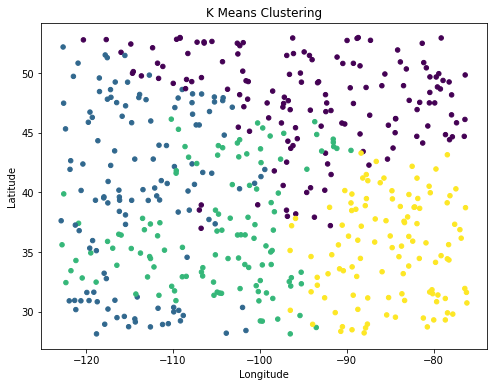

In [27]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
scatter = ax.scatter( df2["Longitude"],df2["Latitude"] , c=df2["ClusterID"] , s=20,)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K Means Clustering")
fig.show()

#### Clustering with Heirarchical Algorithm

In [28]:
agg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
agg.fit(scaled_df)
df2['ClusterID_agg'] = agg.labels_
df2[["Latitude" , "Longitude" , "Birth Date" ,"ClusterID_agg"]]

,Latitude,Longitude,Birth Date,ClusterID_agg
0,41.197746,-88.15758,1524447636,0
1,41.488365,-87.75167,1528162636,0
2,40.973595,-87.57315,1517638013,0
3,35.314070,-116.94493,1545264278,3
4,50.545383,-111.17417,1545864456,1
...,...,...,...,...
495,41.910698,-99.43287,1549424809,2
496,47.444060,-89.23278,1523391105,1
497,47.805290,-101.41159,1553738240,1
498,43.832080,-108.62118,1554232365,3


Text(0.5, 1.0, 'Hierarchial Clustering')

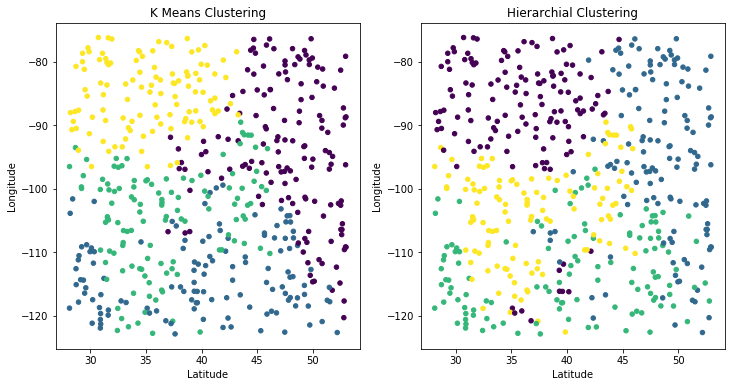

In [29]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax1.scatter(df2["Latitude"] , df2["Longitude"] , c=df2["ClusterID"] , s=20)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("K Means Clustering")

ax2 = fig.add_subplot(122)
ax2.scatter(df2["Latitude"] , df2["Longitude"] , c=df2["ClusterID_agg"] , s=20)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Hierarchial Clustering")

Dividing the data into different clusters based on results from K means. As K means was able to give proper cluster we choose K means Clustering over Aglomerative Clustering.

In [30]:
df_cluster1 = df2[df2["ClusterID"]==0]
df_cluster2 = df2[df2["ClusterID"]==1]
df_cluster3 = df2[df2["ClusterID"]==2]
df_cluster4 = df2[df2["ClusterID"]==3]

In [31]:
df_cluster1.columns

Index(['Latitude', 'Longitude', 'Birth Date', 'visibility', 'timezone',
       'main.temp', 'main.feels_like', 'main.temp_min', 'main.temp_max',
       'main.pressure', 'main.humidity', 'wind.speed', 'wind.deg',
       'clouds.all', 'sys.sunrise', 'sys.sunset', 'Clouds', 'Clear', 'Snow',
       'Fog', 'Rain', 'Mist', 'Drizzle', 'ClusterID', 'ClusterID_agg'],
      dtype='object')

In [32]:
def statistics(cluster):
    stats = cluster.describe().transpose()
    return stats[["min","mean","max"]]    

In [33]:
stats_all = statistics(df_cluster1)
stats_all.columns = ["min1" ,"mean1" ,"max1"]

stats2 = statistics(df_cluster2)
stats2.columns = ["min2" ,"mean2" ,"max2"]

stats3 = statistics(df_cluster3)
stats3.columns = ["min3" ,"mean3" ,"max3"]

stats4 = statistics(df_cluster4)
stats4.columns = ["min4" ,"mean4" ,"max4"]

stats_all = stats_all.join(stats2)
stats_all = stats_all.join(stats3)
stats_all = stats_all.join(stats4)
stats_all.loc[['visibility','main.temp', 'main.feels_like', 'main.temp_min', 'main.temp_max',
       'main.pressure', 'main.humidity', 'wind.speed', 'wind.deg',  'Rain',
       'Clear', 'Clouds', 'Thunderstorm', 'Snow', 'Mist', 'Haze', 'Drizzle'],:]

,min1,mean1,max1,min2,mean2,max2,min3,mean3,max3,min4,mean4,max4
visibility,201.00,14560.904058,24140.00,402.00,13791.687689,40233.00,8047.00,15858.576862,16093.00,402.00,14241.343961,16093.00
main.temp,243.60,256.871310,269.17,249.82,272.454444,290.56,256.97,270.594746,287.86,265.26,282.008468,298.08
main.feels_like,238.60,250.752828,264.95,244.10,267.486270,288.60,250.54,265.215000,284.06,261.08,278.945405,296.28
main.temp_min,243.60,255.974759,267.59,249.82,271.275000,290.56,254.15,268.442881,287.86,262.59,280.635586,298.08
main.temp_max,243.60,257.740828,272.59,249.82,273.477698,290.56,259.15,272.418136,288.15,267.15,283.353784,298.08
main.pressure,1005.00,1021.165517,1038.00,999.00,1013.222222,1024.00,1005.00,1016.059322,1025.00,1007.00,1023.540541,1028.00
main.humidity,65.00,84.151724,100.00,32.00,77.722222,100.00,32.00,73.220339,100.00,44.00,87.288288,100.00
wind.speed,0.45,3.791103,11.02,0.21,3.821429,11.96,0.54,3.884915,13.29,0.23,4.115586,17.50
wind.deg,1.00,142.686756,360.00,1.00,198.250632,360.00,10.00,190.437115,360.00,10.00,207.244677,360.00
Rain,0.00,0.000000,0.00,0.00,0.079365,1.00,0.00,0.000000,0.00,0.00,0.216216,1.00


**Cluster Analysis**

Cluster 1: <br>
Based on the above parameters , it can be clearly observed that cluster 4 is coldest (considerably low average temperature) , has maximum snowfall, and has very low visibility. This indicates that this cluster represents Winter season.

Cluster 4 : <br>
Cluster 1 has very high rainfall, thunderstorm & drizzle amongst all the other clusters. Such climate usually hints a Spring season.

Cluster 2 & 3 : 
Both these clusters have somewhat similar overall temperature range, windspeed and negligible rain. They suggest to be Summer and Fall. The major difference is that, Cluster 2 has reasonably cloudy weather, mild snowfall and poor visibility as compared to cluster3. Where as Cluster 3 is characterized by extreme clarity in atmosphere , highest visibility and least humidity. 
From these observation, it is safe to assume that cluster Cluster 2 represents Fall season and Cluster 3 represents Summer.

#### Labeling data for supervised learning

In [34]:
def generate_label(cluster):
    if cluster==0:
        return("Spring")
    elif cluster==1:
        return("Fall")
    elif cluster==2:
        return("Summer")
    else:
        return("Winter")
    

In [35]:
df2.columns

Index(['Latitude', 'Longitude', 'Birth Date', 'visibility', 'timezone',
       'main.temp', 'main.feels_like', 'main.temp_min', 'main.temp_max',
       'main.pressure', 'main.humidity', 'wind.speed', 'wind.deg',
       'clouds.all', 'sys.sunrise', 'sys.sunset', 'Clouds', 'Clear', 'Snow',
       'Fog', 'Rain', 'Mist', 'Drizzle', 'ClusterID', 'ClusterID_agg'],
      dtype='object')

In [36]:
df_train_input = df2[["Latitude","Longitude","Birth Date","ClusterID"]]
df_train_input["Season"] = df2["ClusterID"].apply(generate_label) 
df_train_input.head(15)

,Latitude,Longitude,Birth Date,ClusterID,Season
0,41.197746,-88.157580,1524447636,3,Winter
1,41.488365,-87.751670,1528162636,3,Winter
2,40.973595,-87.573150,1517638013,3,Winter
3,35.314070,-116.944930,1545264278,2,Summer
4,50.545383,-111.174170,1545864456,0,Spring
5,29.373638,-97.944320,1548972565,2,Summer
6,35.124146,-96.523360,1555512493,3,Winter
7,28.417503,-101.606804,1555891024,1,Fall
8,41.934376,-94.590360,1543961664,2,Summer
9,28.954363,-87.621890,1520765198,3,Winter


Text(0.5, 1.0, 'Classes Distribution')

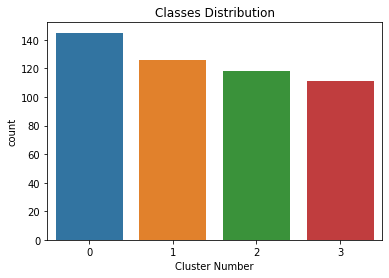

In [37]:
plt.figure(1,figsize=(6,4))
sns.countplot(df_train_input["ClusterID"])
plt.xlabel("Cluster Number")
plt.title("Classes Distribution")

### Classification Models:

We will apply 2 classification models - 
1. Random Forest
2. XGBoost

In [38]:
# Train - Test Split
X_train, X_test , y_train , y_test = train_test_split(df_train_input[["Latitude","Longitude","Birth Date"]] , 
                                                      df_train_input["ClusterID"] , 
                                                      test_size=0.2 , random_state=42)

In [39]:
# Scaling Inputs (Standardising)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Random Forest Classifier**

In [ ]:
estimators = [50,90,250,300,350,500,750,800]

cv_scores=[]

# perform 3-fold cross validation
for a in estimators:
    Rf=RandomForestClassifier(n_estimators = a)
    scores = cross_val_score(Rf, X_train, y_train, cv=5, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_estimator = estimators[MSE.index(min(MSE))]
print('\nThe optimal estimator of Random Forest is %f.' % optimal_estimator)

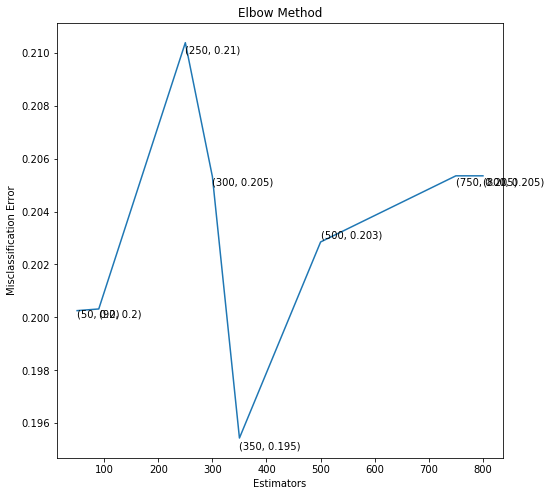

In [40]:
# plot misclassification error vs K 
plt.figure(figsize=(8,8))
plt.plot(estimators, MSE)

for xy in zip(estimators, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.title("Elbow Method")
plt.show()

In [41]:
rf = RandomForestClassifier(n_estimators = optimal_estimator, random_state = 42)

In [42]:
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [43]:
print("The Accuracy of the Random Forest Model is " + str(accuracy_score(y_test,y_pred)*100))

The Accuracy of the Random Forest Model is 81.0


Text(0.5, 1, 'Confusion Matrix')

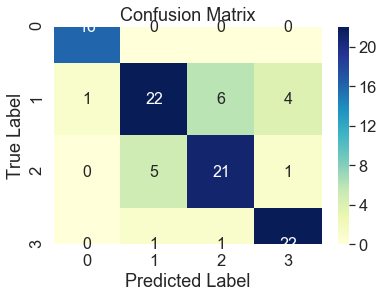

In [44]:
#Plotting Confusion Matrix
x=confusion_matrix(y_test,y_pred)
Cm_df=pd.DataFrame(x)

plt.figure(1,figsize=(6,4))
sns.set(font_scale=1.5,color_codes=True,palette='deep')
sns.heatmap(Cm_df,annot=True,annot_kws={'size':16},fmt='d',cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix')

#### XGBoost

In [45]:
estimators = [50,90,250,300,400,500]

cv_scores=[]

# perform 3-fold cross validation
for a in estimators:
    xgb=XGBClassifier(n_estimators=a,learning_rate=0.1)
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy',n_jobs=1)
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_estimator = estimators[MSE.index(min(MSE))]
print('\nThe optimal estimator of Xgboost is %f.' % optimal_estimator)


The optimal estimator of Xgboost is 90.000000.


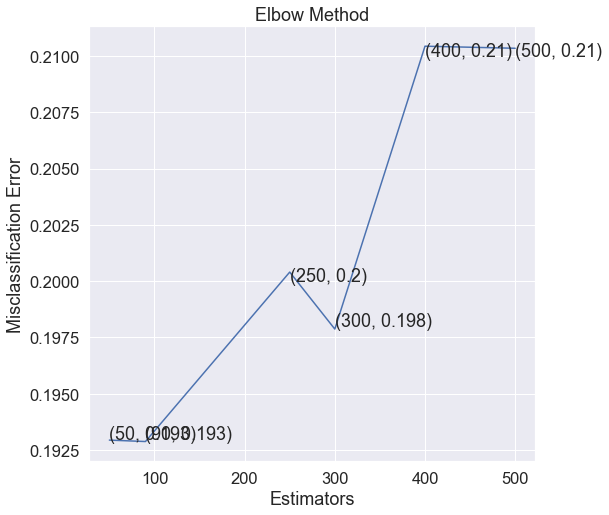

In [46]:
# plot misclassification error vs K 
plt.figure(figsize=(8,8))
plt.plot(estimators, MSE)

for xy in zip(estimators, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Estimators')
plt.ylabel('Misclassification Error')
plt.title("Elbow Method")
plt.show()

In [47]:
xgb = XGBClassifier(n_estimators=250,learning_rate=0.1,)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
y_pred = xgb.predict(X_test)
print("The Accuracy of the Gradient Boosted Model is " + str(accuracy_score(y_test,y_pred)*100))

The Accuracy of the Gradient Boosted Model is 82.0


Text(0.5, 1, 'Confusion Matrix')

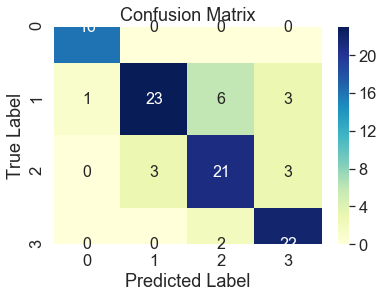

In [49]:
#Plotting Confusion Matrix
x=confusion_matrix(y_test,y_pred)
Cm_df=pd.DataFrame(x)

plt.figure(1,figsize=(6,4))
sns.set(font_scale=1.5,color_codes=True,palette='deep')
sns.heatmap(Cm_df,annot=True,annot_kws={'size':16},fmt='d',cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix')

#### Conclusion

Given adequate and relevant climate information, season at the time of birth can be calculated from location and birth date.
Although, the accuracy of the model highly depends on the weather data available.
<br>
Because of the tilt of earth, and division of continents into northern and southern hemisphere, different seasons can be observed in different parts of the world. For eg, in Australia, Christmas is celebrated during summer vacation !
Hence, to predict correct seasons , dates along with geographical position and climate statistics are required. 

In order to classify new data point into one of the 4 seasons, a supervised learning algorithm needs to be build to train the model. For this challenge, original data had no labels. To remediate this, in the above implementation, labels were generated based on the climatic conditions obtained from third party API. Major assumption in creating the ground truth for season label was that climatic conditions on the day and time of birth can correctly represent the season at that location.

Once, climatic data was available, original data was split into 4 clusters. K-means and hierarchical clustering techniques were used to classify the data. Properties of these generated 4 clusters which were identified to tag appropriate weather labels. 

The labelled data was then used to build 2 different classifiers.
From the accuracy metric, it is clear that RandomForest implementation works better. It provides an accuracy of 81%
Where as that of XGBoost is 82%

Hence, in conclusion it can be said that, with accurate classification and prediction tasks, seasons can be predicted. 